In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [2]:
data = pd.read_csv('data/df_12H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (52536, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 SepsisLabel
0.0    39402
1.0    13134
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

In [ ]:
# split
train_df, test_df = split_train_test_data_v2(data)

# Extraction de séquences et normalisation
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=drop_column, inplace=True)
/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=drop_column, inplace=True)


In [4]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((24514, 6, 35), (24514,), (6132, 6, 35), (6132,))

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten


def build_and_train_transformer_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=256, num_heads=1, dff=64):
    """
    Construit et entraîne un modèle Transformer personnalisé pour la prédiction sur des séquences temporelles.

    Args:
    - X_train: Séquences d'entraînement.
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation.
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.
    - num_heads: Nombre de têtes pour l'attention multi-têtes.
    - dff: Dimension du réseau feed-forward dans le bloc Transformer.

    Returns:
    - keras.models.Model: Modèle Transformer personnalisé entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """

    inputs = Input(shape=input_shape)

    # Couches de Transformer
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention = Dropout(0.3)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Réseau feed-forward
    ff = Dense(dff, activation='relu')(attention)
    ff = Dropout(0.3)(ff)
    ff = Dense(input_shape[-1])(ff)
    ff = Add()([attention, ff])
    ff = LayerNormalization(epsilon=1e-6)(ff)

    # Flatten pour rendre compatible avec la dernière couche
    flatten = Flatten()(ff)
    outputs = Dense(1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


In [6]:
input_shape = (6, 35)
model_transformer, history_transformer = build_and_train_transformer_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)


Epoch 1/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4600 - loss: 0.8644 - val_accuracy: 0.5514 - val_loss: 0.7058
Epoch 2/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5445 - loss: 0.7121 - val_accuracy: 0.5766 - val_loss: 0.6822
Epoch 3/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5698 - loss: 0.6862 - val_accuracy: 0.6040 - val_loss: 0.6621
Epoch 4/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6002 - loss: 0.6675 - val_accuracy: 0.6230 - val_loss: 0.6455
Epoch 5/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6179 - loss: 0.6524 - val_accuracy: 0.6466 - val_loss: 0.6276
Epoch 6/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6392 - loss: 0.6333 - val_accuracy: 0.6585 - val_loss: 0.6106
Epoch 7/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6674 - loss: 0.6107 - val_accuracy: 0.6849 - val_loss: 0.5907
Epoch 8/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6830 - loss: 0.5949 - val_accuracy: 0.6996 - v

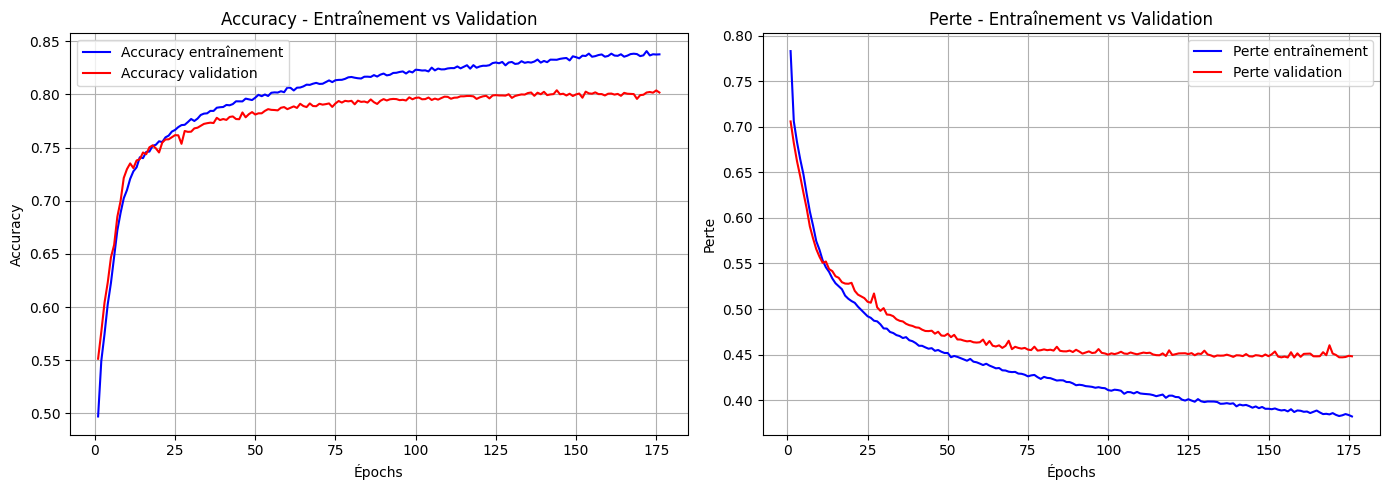

In [7]:
plot_training_history(history_transformer)

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
Accuracy: 0.8020
Precision: 0.7595
Recall: 0.8025
F1-Score: 0.7804
AUROC: 0.8727


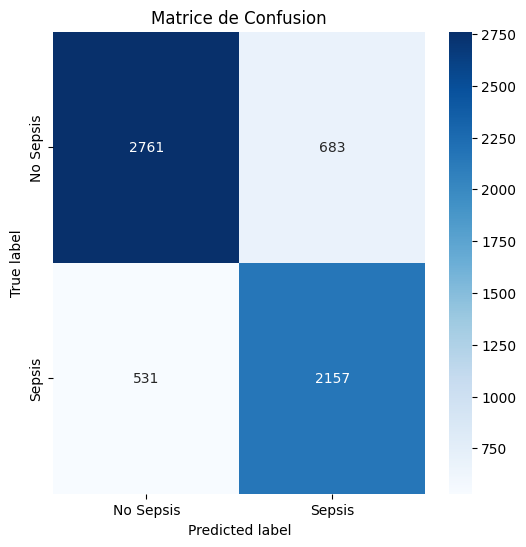

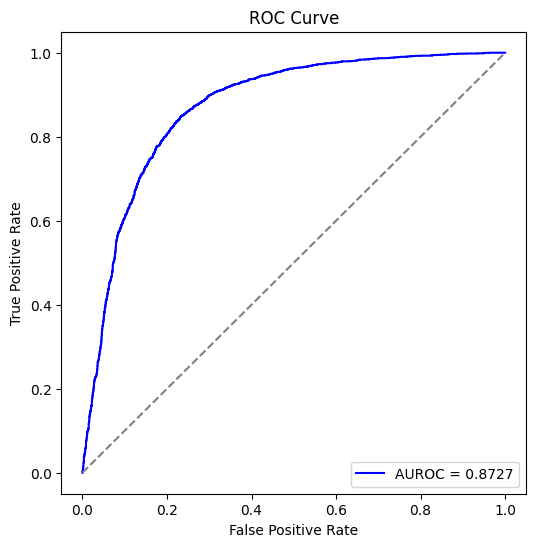

In [8]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_transformer, normalize_sequences_test, labels_test)